<a href="https://colab.research.google.com/github/LudwigMeder/Time-Series-Prediction-of-the-Tide-Gauge-in-St.-Pauli/blob/main/2_BaselineModel/baseline_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Baseline Model

## Table of Contents
1. [Model Choice](#model-choice)
2. [Feature Selection](#feature-selection)
3. [Implementation](#implementation)
4. [Evaluation](#evaluation)


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
# Import your chosen baseline model
# Example: from sklearn.linear_model import LogisticRegression


## Model Choice

We choose the simplest neural network with 48 input and one output neuron. This model takes the water levels of the last 48 hours and predicts the level for the following hour.


## Feature Selection

We will only use the water level feature of the dataset, to keep the baseline model as simple as possible. Afterwards we can asses how big the impact of the wind is, by comparing future models with this basic model.

Note, wind impact on water level is mostly small, only storm events have higher influence.


In [27]:
# Filepaths to the tide data and a list of continous sequences stored in the GitHub repository:
file_path_tide = 'https://raw.githubusercontent.com/LudwigMeder/Time-Series-Prediction-of-the-Tide-Gauge-in-St.-Pauli/main/2_BaselineModel/Tide_level_data.csv'
file_path_sequences = 'https://raw.githubusercontent.com/LudwigMeder/Time-Series-Prediction-of-the-Tide-Gauge-in-St.-Pauli/main/2_BaselineModel/Subsequences.csv'
tides_data = pd.read_csv(file_path_tide)
subsequences = pd.read_csv(file_path_sequences)

#choose the biggest subset without missing values
inter_data = tides_data[subsequences[subsequences.columns[1]][0]:]

#convert the data into a 1D numpy array
tides = inter_data[tides_data.columns[1]].values

#function to split the data into features and labels using a moving window aproach
def create_time_series_dataset(time_series, n_steps, n_out):
    features, labels = [], []
    for i in range(len(time_series) - n_steps - n_out):
        feature = time_series[i:i+n_steps]  # Two consecutive values as features
        label = time_series[i+n_steps:i+n_steps+n_out]      # The upcoming value as label
        features.append(feature)
        labels.append(label)
    return np.array(features), np.array(labels)

#define the lenght of the feature vector
input_lenght = 48
output_lenght = 1

#calculate features and labels
X, Y = create_time_series_dataset(tides, input_lenght,output_lenght)


# Fixed Partitioning
lenght = np.shape(X)[0]
X_train = X[:int((lenght * 0.8)//1),:]
Y_train = Y[:int((lenght * 0.8)//1)]
X_test = X[int((lenght*0.8)//1) :,:]
Y_test = Y[int((lenght*0.8)//1) :,]

#Splitting the dataset
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
# Assigning the data randomly into the test and training chunks did not increase the accuracy of our model,
# therefore we continue in this baseline notebook with the fixed partitioning to be able to later visualize a longer time series!

#scale the training data and the test data (only scaling on the training data set, in order to avoid spill over of information to the test data set)
# scale X (historical) values train and test and not Y (labels) because Y should be stay in its originally size for better understandability
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

# trying without scaling -> the difference of the root mean square error of calculations with and without scaling is only 0.21cm by a window of 48h
#X_train_norm = X_train
#X_test_norm = X_test


## Implementation





This first "model" only repeats the latest value. Since we look at hourly water level data, the resulting mean error gives us an idea on how much the water level usually varies in on hour on average. This is a useful quantity to assess the performance of future models, i.e. we can not only evaluate the errors of future models against the absolute range of water levels but also specifically against the "range" of hourly variations.

In [28]:
def basemodel(ts):
  return ts[-1]

pred = []

for i in X_test:
  pred.append(basemodel(i))

In [29]:
b_mse = mean_squared_error(Y_test,pred)
print("RMSE: "+str(np.round(np.sqrt(b_mse),2))+" cm")#root mean squared error

RMSE: 70.02 cm


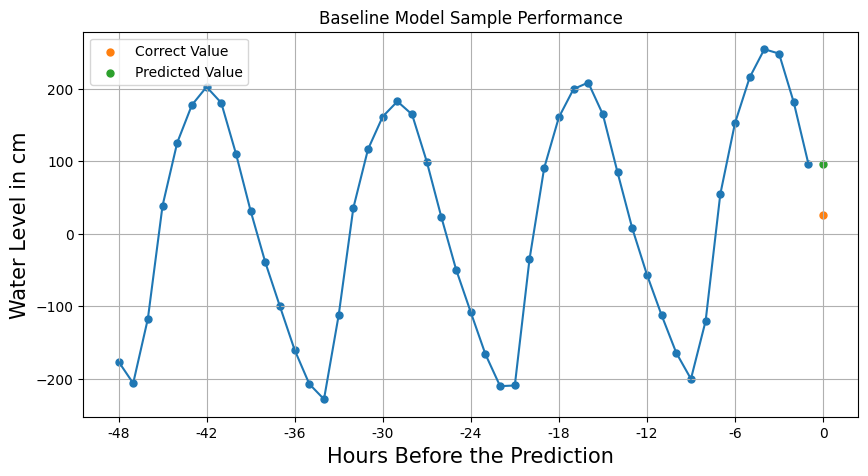

In [30]:
#create simple plot
plt.figure(figsize=[10,5])
plt.scatter(np.arange(0,input_lenght,1),X_test[100],s=25)
plt.plot(np.arange(0,input_lenght,1),X_test[100])
plt.scatter([input_lenght],Y_test[100],label = "Correct Value",s=25)
plt.scatter([input_lenght],pred[100], label = "Predicted Value",s=25)
plt.legend()
plt.xticks(ticks=np.arange(0,49,6),labels=np.arange(-48,1,6))
plt.ylabel("Water Level in cm",fontsize=15)
plt.xlabel("Hours Before the Prediction",fontsize=15)
plt.title("Baseline Model Sample Performance")
plt.grid()

First simple model which repeats the last value:  
Data: Tide level data set which has no missing values  
Training: 80%, testing 20%  
Input: last 48 hours, Output: 1 value for the next hour  
RMSE: 0.7m! - scale of tide is +-2m.

##This is our baseline model:
A Simple neural network with two dense layers - one as an input with 48 neurons and one as an output layer with just one neuron.

For the optimizer we choose Adam and for the loss function we use the mean squared error.

In [31]:
# Define simple model, with just one input and one output neuron
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units = input_lenght),
    tf.keras.layers.Dense(units = 1)            # no activation function
])

#compile and train model
model.compile(optimizer = "adam", loss = "mean_squared_error")
history = model.fit(X_train_norm,Y_train, epochs = 50)


Epoch 1/50
1807/1807 [==============================] - 4s 2ms/step - loss: 2938.9155
Epoch 2/50
1807/1807 [==============================] - 3s 2ms/step - loss: 484.7852
Epoch 3/50
1807/1807 [==============================] - 4s 2ms/step - loss: 329.4265
Epoch 4/50
1807/1807 [==============================] - 3s 2ms/step - loss: 275.3164
Epoch 5/50
1807/1807 [==============================] - 3s 2ms/step - loss: 243.3127
Epoch 6/50
1807/1807 [==============================] - 3s 2ms/step - loss: 223.4067
Epoch 7/50
1807/1807 [==============================] - 4s 2ms/step - loss: 211.9125
Epoch 8/50
1807/1807 [==============================] - 3s 2ms/step - loss: 203.6000
Epoch 9/50
1807/1807 [==============================] - 3s 2ms/step - loss: 198.4382
Epoch 10/50
1807/1807 [==============================] - 3s 2ms/step - loss: 194.2535
Epoch 11/50
1807/1807 [==============================] - 4s 2ms/step - loss: 191.2024
Epoch 12/50
1807/1807 [==============================] - 3s 2m

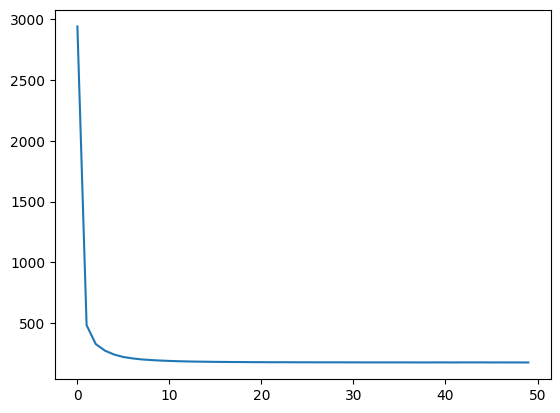

In [32]:
plt.plot(history.history["loss"])

## Evaluation

To evaluate this baseline model and future more complex models we used the root mean squared error. This parameter shows us the mean deviation of our prediction to the true tide values in cm. Since these are absolute errors (not relativ) we have to relate them to either total tide ranges or expected hourly variations in the water level in order to assess the quality of our predictions.



In [33]:
#make prediction
Y_pred = model.predict(X_test_norm)

452/452 [==============================] - 1s 1ms/step


In [34]:
# evaluate the prediction
mse = mean_squared_error(Y_test, Y_pred)
#print(np.mean(np.std([y_test[0],y_pred])))
print("RMSE: "+str(np.round(np.sqrt(mse),2))+" cm")#RMSE

RMSE: 12.14 cm


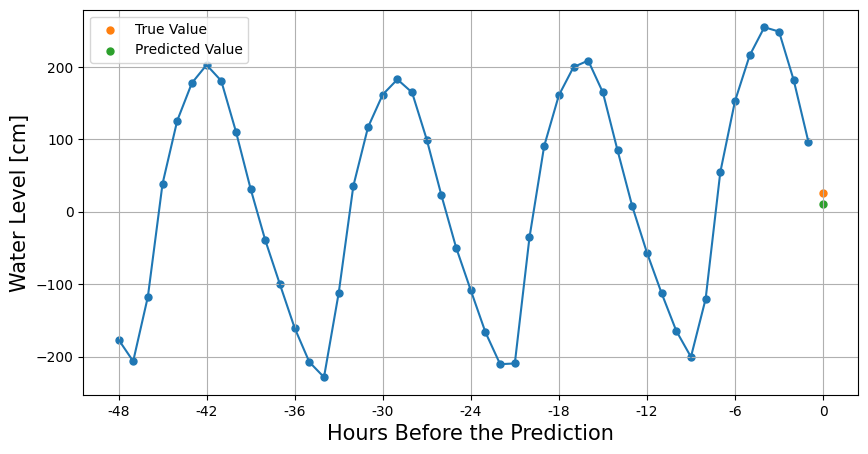

In [35]:
#create simple plot to visualize the functionality: 48 hours of tide data as input (blue dots and line) and one value as output (green dot shows the models prediction, orange dot the true value)
# Note that this is only one example window, which might not be representative for the models performance!
plt.figure(figsize=[10,5])
plt.scatter(np.arange(0,input_lenght,1),X_test[100],s=25)
plt.plot(np.arange(0,input_lenght,1),X_test[100])
plt.scatter([input_lenght],Y_test[100],label = "True Value",s=25)
plt.scatter([input_lenght],Y_pred[100], label = "Predicted Value",s=25)
plt.legend()
plt.xticks(ticks=np.arange(0,49,6),labels=np.arange(-48,1,6))
plt.ylabel("Water Level [cm]",fontsize=15)
plt.xlabel("Hours Before the Prediction",fontsize=15)
plt.grid()

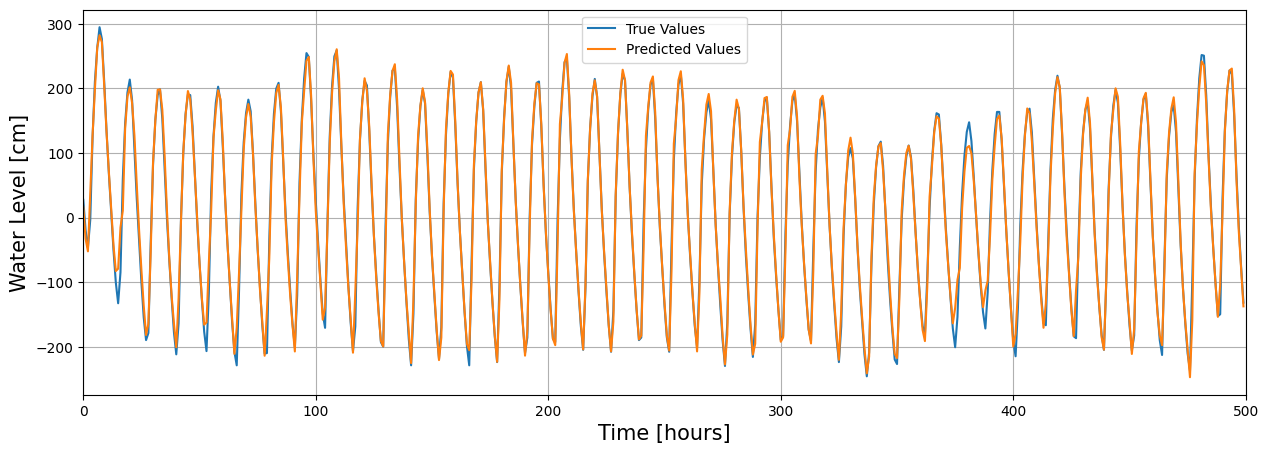

In [36]:
#create another plot displaying a longer timeseries:
# Note that this is still the result of single step predictions based on the respective previous 48 hours!
plt.figure(figsize=[15,5])
plt.plot(Y_test[:500], label = "True Values")
plt.plot(Y_pred[:500],label = "Predicted Values")
plt.legend()
plt.ylabel("Water Level [cm]",fontsize=15)
plt.xlabel("Time [hours]",fontsize=15)
plt.xlim(0,500)
plt.grid()

Summary:



*   Simple neural network with two dense layers - one as an input and one as an output layer.  

*   Data set and train/test ratio is unchanged.
*   Input: last 48 hours, Output: 1 value for the next hour

*   Training data was scaled, impact is 0.21cm
*   RMSE: 12.14 cm

*   The time series plot suggests that the errors mainly occur during high tide or low tide, where it tends to underestimate both extremes. (Which means this model would rather fail to predict a flooding event, then predict false ones.)
*   To put 12.14 cm a little in perspective: The mean high water in St. Pauli is 217 cm and the parking lot is flooded at water levels above 290 cm. And as discussed above: The water level varies (on average) ~70cm per hour, which means our model deviates less then 20% from the expected variations. For a simple baseline model this seems acceptable.







  
  
